# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy

device = torch.device('cpu')
# training on GPU in not awailable right now

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
#             print(type(array))
        
        array = array.reshape(1, self.height,self.width)

#         print(type(array))
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
# transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=1),
#         transforms.RandomRotation(degrees=45),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomGrayscale(p=0.1)
#     ]),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]) normalize images
# ])

# color_transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=0.4),
#         transforms.ColorJitter(brightness=0.5),
#         transforms.ColorJitter(brightness=0.6),
#         transforms.ColorJitter(brightness=0.7)
#     ]),
#     transforms.ToTensor()
# ])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations)
#           BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations)
print(dataset)

683, 76


<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


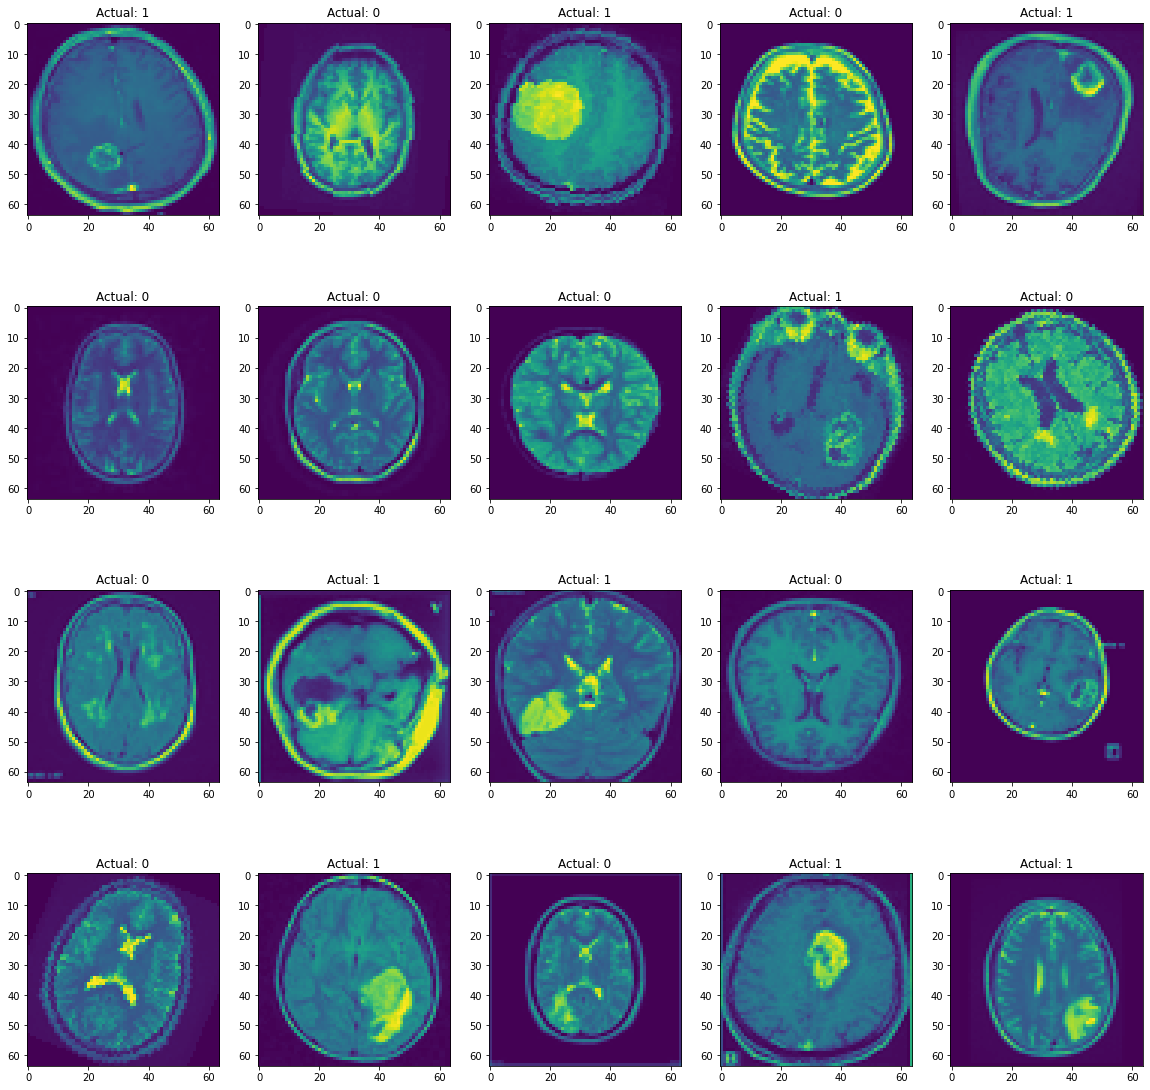

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.9)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [9]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        # print(x.shape)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)
        # print(x.shape)

        return x

In [10]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 201
plot = False

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

In [12]:
loss_list_dumb = train(model, train_data, test_data, num_epochs=num_epochs)

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  0.6716, Accuracy:  0.5521
Epochs: 10 Loss:  0.7831, Accuracy:  0.5694
Epochs: 20 Loss:  0.6322, Accuracy:  0.6146
Epochs: 30 Loss:  0.5830, Accuracy:  0.6979
Epochs: 40 Loss:  0.6196, Accuracy:  0.6354
Epochs: 50 Loss:  0.6318, Accuracy:  0.6910
Epochs: 60 Loss:  0.6270, Accuracy:  0.7222
Epochs: 70 Loss:  0.3697, Accuracy:  0.6528
Epochs: 80 Loss:  0.6071, Accuracy:  0.7118
Epochs: 90 Loss:  0.8169, Accuracy:  0.7674
Epochs: 100 Loss:  0.5724, Accuracy:  0.7118
Epochs: 110 Loss:  0.5368, Accuracy:  0.7222
Epochs: 120 Loss:  0.3694, Accuracy:  0.6910
Epochs: 130 Loss:  0.4043, Accuracy:  0.7986
Epochs: 140 Loss:  0.3716, Accuracy:  0.7118
Epochs: 150 Loss:  0.3548, Accuracy:  0.7396
Epochs: 160 Loss:  0.3385, Accuracy:  0.7986
Epochs: 170 Loss:  0.4774, Accuracy:  0.7986
Epochs: 180 Loss:  0.2544, Accuracy:  0.7986
Epochs: 190 Loss:  0.3929, Accuracy:  0.7604
Epochs: 200 Loss:  0.4498, Accuracy:  0.6840


In [13]:
loss_list = train(model, train_data, test_data, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  0.4974, Accuracy:  0.7431
Epochs: 10 Loss:  0.2634, Accuracy:  0.7326
Epochs: 20 Loss:  0.3786, Accuracy:  0.7326
Epochs: 30 Loss:  0.3266, Accuracy:  0.7326
Epochs: 40 Loss:  0.3089, Accuracy:  0.7118
Epochs: 50 Loss:  0.3406, Accuracy:  0.8299
Epochs: 60 Loss:  0.3505, Accuracy:  0.7882
Epochs: 70 Loss:  0.2925, Accuracy:  0.8368
Epochs: 80 Loss:  0.2852, Accuracy:  0.7743
Epochs: 90 Loss:  0.3065, Accuracy:  0.7812
Epochs: 100 Loss:  0.4173, Accuracy:  0.7431
Epochs: 110 Loss:  0.3075, Accuracy:  0.7535
Epochs: 120 Loss:  0.1883, Accuracy:  0.8299
Epochs: 130 Loss:  0.2188, Accuracy:  0.8090
Epochs: 140 Loss:  0.2693, Accuracy:  0.7431
Epochs: 150 Loss:  0.2102, Accuracy:  0.7604
Epochs: 160 Loss:  0.3123, Accuracy:  0.8125
Epochs: 170 Loss:  0.3104, Accuracy:  0.7812
Epochs: 180 Loss:  0.1713, Accuracy:  0.8194
Epochs: 190 Loss:  0.1924, Accuracy:  0.8194
Epochs: 200 Loss:  0.3319, Accuracy:  0.8576


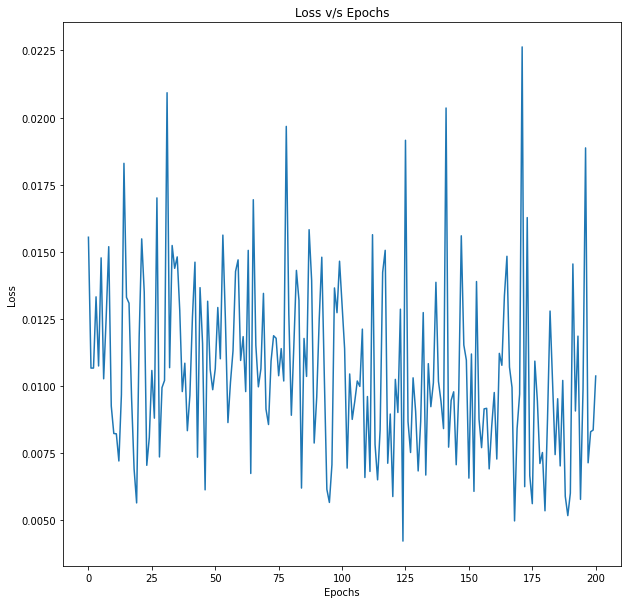

In [14]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n'
          f'Test Loss: {test_loss/len(image): .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test(model, test_loader, loss_fn)

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.83 
Test Loss:  55.89


(55.894975907376185, tensor(63.))

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


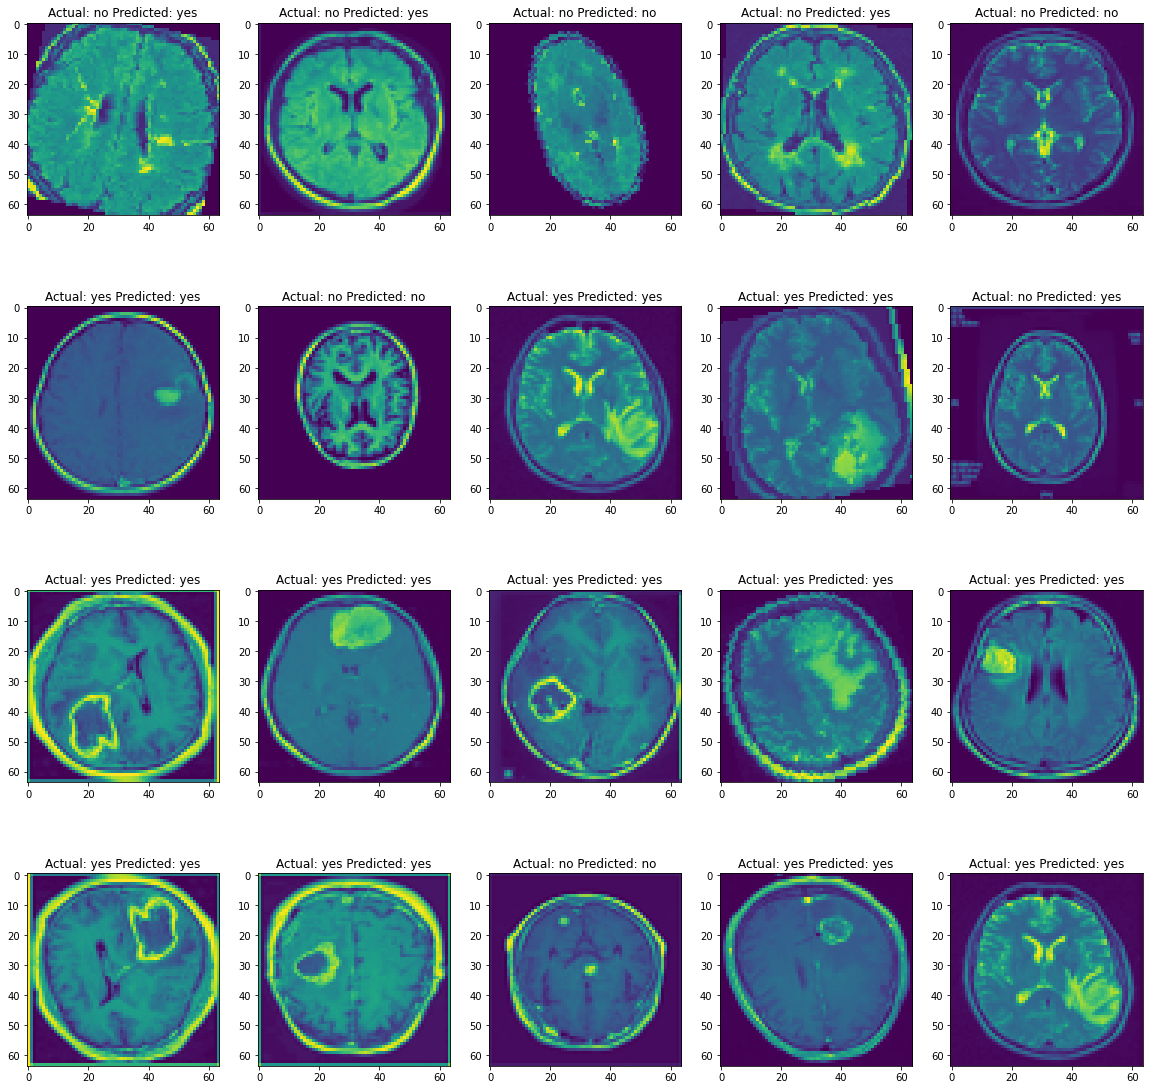

actual accuracy:  0.80


In [16]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
#     print(pred)
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [17]:
raw_predictions

[tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1])]

### SyMPC part


In [18]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [19]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [20]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [21]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    if i == 20: break
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(ptrs)



<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


20

In [22]:
mpc_model = model.share(session)
mpc_model

In [23]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2022-02-15T21:24:56.537077+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e041f62a5ee4ca6bbc9cc762a209dda>.
[2022-02-15T21:24:56.544798+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81067cb2fdf840e18ae544df4825fcd0>.
[2022-02-15T21:26:01.579629+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a62fdef51884d2a8099feefcab0aff9>.
[2022-02-15T21:26:01.583172+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab5bb39c5c39478b9d164dc2df6b6f4a>.
[2022-02-15T21:26:30.601405+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb7ccecae77349bbadfeb45344c332cd>.
[2022-02-15T21:26:30.607417+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a04c1e6dd5bf463bb05c2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3445,  0.4082]])


[2022-02-15T21:26:41.783977+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e90c1e8afe842c0a2463b7b4c581141>.
[2022-02-15T21:26:41.787979+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e5b39b5c46b42088bff79ad87ba5a84>.
[2022-02-15T21:27:43.599816+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 52f6dfaaa4614bd9820b614795e4b29c>.
[2022-02-15T21:27:43.603820+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e517f109849042a2b76db82397584756>.
[2022-02-15T21:28:15.137794+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98375b44e16f4f3e98b754ef786ce197>.
[2022-02-15T21:28:15.141930+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85185668af4047f7a1efb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 35.7906, -30.5779]])


[2022-02-15T21:28:25.414948+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c741ef9e177413d9cd5cf38d88d02fc>.
[2022-02-15T21:28:25.419169+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e974d9ee8e1641a49662170411c7c2e1>.
[2022-02-15T21:28:25.427076+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 269b6c9dfd924d748af411fdd80375cb>.
[2022-02-15T21:28:25.430519+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3aa4626feef74a0e8e2d48f0fa073cfe>.
[2022-02-15T21:28:25.441851+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9d0dd4864254892ab692c4c37f01f37>.
[2022-02-15T21:28:25.445738+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a87298dc5dfd45f2a7801

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 8.0557, -7.6448]])


[2022-02-15T21:30:03.880663+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be82ac3e1ceb444fa65c3adc7118d8b4>.
[2022-02-15T21:30:03.892260+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc97f4ae15294022b25afe14224d05ec>.
[2022-02-15T21:30:03.903794+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38e6a917190440b49162af920c4f7c3c>.
[2022-02-15T21:30:03.905793+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93c0b3e16b9a45c7abf2eac02c1a42b6>.
[2022-02-15T21:30:03.915834+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e530914cf0f347e1b33c48adb50890b9>.
[2022-02-15T21:30:03.920831+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc43b3e91b1d43d7a1068

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0827,  0.2255]])


[2022-02-15T21:31:49.419445+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4254219088204d54a8499fd8526ee1a7>.
[2022-02-15T21:31:49.429513+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf7dcc8673a34ed2a302ebdb4e4d3d76>.
[2022-02-15T21:31:49.429513+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eea0a50896354feba471a85fc6890a85>.
[2022-02-15T21:31:54.187077+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79169518e4e344a69ff0bdaa8da771f6>.
[2022-02-15T21:31:54.191057+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87708293afb2489bb323973d0d4788d8>.
[2022-02-15T21:33:04.310896+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87004867b7ad4b5eac7fa

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4661, -0.3063]])


[2022-02-15T21:33:53.298797+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78fd5241a54b4f09855fa353637dc8d2>.
[2022-02-15T21:33:53.301798+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 558d6b08c63e4b08b86d251afe0fcde8>.
[2022-02-15T21:33:53.307801+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81506469c33543378f6903e6f3300325>.
[2022-02-15T21:33:53.312580+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb19d445bf214667850f8077dade6863>.
[2022-02-15T21:33:53.469268+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3f1e47a21954f73b3a7a6a585a9d4bb>.
[2022-02-15T21:33:53.476800+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aaca59e950d24c4facb65

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.5457, 2.0257]])


[2022-02-15T21:35:29.768319+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f39f94eb9a4a4549add90cb060845209>.
[2022-02-15T21:35:29.773317+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a8cee2339ba47d5a15a61d4e7aa685b>.
[2022-02-15T21:35:29.779420+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d41973b42734ab1a2806a3f0d3fbb17>.
[2022-02-15T21:35:29.783530+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a18ca4833ff941928b79cb5557c24a2c>.
[2022-02-15T21:35:29.796003+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cadc6d79ae7f41fdacd8b7a22b277dd7>.
[2022-02-15T21:35:29.798492+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94186471ed3b4fd4a28f1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.8158, -3.3844]])


[2022-02-15T21:37:05.121277+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d09f6ea872024bf1ba9c2444b21d7371>.
[2022-02-15T21:37:05.125125+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cac47ebfc03455dbe5480dcafa96175>.
[2022-02-15T21:37:59.622105+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3656a83b62bc4cf1a72b6c48b2cb8fbb>.
[2022-02-15T21:37:59.625103+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e1b67032a334d08b6e3a88d29befb58>.
[2022-02-15T21:38:27.021791+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d08d1ae3f3944b5e87281b4c11b50f3a>.
[2022-02-15T21:38:27.021791+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3288891d75a4f3896b21

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 27.5588, -24.0870]])


[2022-02-15T21:38:36.551761+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a15911aafce4950a33dab8881c670cb>.
[2022-02-15T21:38:36.555285+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6cc54f1448a4173a11398710cbfd709>.
[2022-02-15T21:38:36.566260+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 146666a4b9fa481a87641254e4133f39>.
[2022-02-15T21:38:36.570072+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e818a6f9b0f4f2681e823ae94dc724f>.
[2022-02-15T21:38:36.575259+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02f556a00f534692847ec3b27bf94486>.
[2022-02-15T21:38:36.579819+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 578ae415ec744dcf8f327

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2601,  0.3669]])


[2022-02-15T21:40:07.910504+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f154bc22107745b898d443f71b21fd3f>.
[2022-02-15T21:40:07.914542+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b99d51baf544a32b3c454eb4b228f04>.
[2022-02-15T21:41:06.934844+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5746e0e8766f4251b4aa7ab3f4a5fb4e>.
[2022-02-15T21:41:06.934844+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ac370c00d854887b3a05ee0112cc0d3>.
[2022-02-15T21:41:34.036285+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 468b1f706a004d1eb5d008ca652e3182>.
[2022-02-15T21:41:34.039287+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c6d0bce652044f78942d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-9.5553,  7.5494]])


[2022-02-15T21:41:43.757983+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81265618e7044a0a8216677ae8685226>.
[2022-02-15T21:41:43.760961+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cfda32676c94bc69daa74d133630ad6>.
[2022-02-15T21:41:43.765947+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1517c4c3beef4d529c50f8f1eff35d7d>.
[2022-02-15T21:41:43.768948+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 113c384b6e5d49b2afb3d9004a795dc3>.
[2022-02-15T21:41:43.968888+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3d5f3eb5c714327890b561ac95aa168>.
[2022-02-15T21:41:43.972658+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d5d0668d82d4f86ac2a1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 37.9452, -47.8300]])


[2022-02-15T21:43:14.827105+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b36f8ef315974340b5b78a2e6a68238b>.
[2022-02-15T21:43:14.833633+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2df2ef1a4c024c1da39ea7e41a28ec90>.
[2022-02-15T21:43:14.843813+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a5a9b4628664458be57733916c549c1>.
[2022-02-15T21:43:14.848867+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1b834c4337e44978bfdc6c5cb300267>.
[2022-02-15T21:43:14.859992+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21cac5296f944b519cab71c6221a0109>.
[2022-02-15T21:43:14.862801+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9202627d6b43471caf584

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 17.6421, -12.0634]])


[2022-02-15T21:45:04.080014+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b9d6a101fa64ebab3b98e8203574397>.
[2022-02-15T21:45:04.083719+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a80c1bf7cd944939a3a04690293faf3>.
[2022-02-15T21:46:01.830377+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf72ca26d877441dbd3c06ab4511f344>.
[2022-02-15T21:46:01.836430+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4a72801b53140c1b515f8bc75885ff8>.
[2022-02-15T21:46:30.945423+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08124904377e4f4383ee0ab3a0eb070e>.
[2022-02-15T21:46:30.947429+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e49de9bb43644fe087b30

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 39.3438, -33.7162]])


[2022-02-15T21:46:40.587467+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 426d74ad100544ce8962fe55d24a3e5d>.
[2022-02-15T21:46:40.591413+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e30fefe9a17145919fe4ffe142cbcceb>.
[2022-02-15T21:46:40.596442+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7182ea9076a4e0d9be4f0c457d5c82d>.
[2022-02-15T21:46:40.599421+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e401e5b10754709830080d127a90091>.
[2022-02-15T21:46:40.800300+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 982d1921480945e1937cc159a07140c2>.
[2022-02-15T21:46:40.803270+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dee683867ea641779da9f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.1989,  1.2860]])


[2022-02-15T21:48:21.873751+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f01b55ba9ab04cfaab5d2340520d8831>.
[2022-02-15T21:48:21.877751+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf7b0a637a6f4781919ffa56f604a8fb>.
[2022-02-15T21:48:21.884071+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7aa15c55e2f748309550fdabf9afb2c1>.
[2022-02-15T21:48:21.887752+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 26815176147341ff82bb02ba98436d8b>.
[2022-02-15T21:48:21.898751+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ee2b6160bbf4310ae3d37326c24c6b3>.
[2022-02-15T21:48:21.902754+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa66a2db17ff42aa93573

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 5.5215, -8.3503]])


[2022-02-15T21:49:58.996936+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a3ad85a77014c4d97ef5169e06e94d2>.
[2022-02-15T21:49:59.000937+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d70263f227b641d9a774372cc9af3bf7>.
[2022-02-15T21:49:59.003995+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63fe637ed8744ee7b20dd315a5cbec1c>.
[2022-02-15T21:49:59.003995+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7fb87f8c43048a9898c2dfa182decfa>.
[2022-02-15T21:49:59.003995+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec7f678fb626459bbbaeb238039c6af0>.
[2022-02-15T21:49:59.019663+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48c191c97b664162a172f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5450,  1.6357]])


[2022-02-15T21:51:34.654698+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63ad572de227498a9272d19f255f7e37>.
[2022-02-15T21:51:34.658701+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40d6f8d7b17d48bfa622a7513cb3f947>.
[2022-02-15T21:51:34.820263+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 563566f2f4614eea9aa254c366808c58>.
[2022-02-15T21:51:34.823008+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e632826d8944a398a0dfdcfee776898>.
[2022-02-15T21:52:31.673344+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7009a8a3d56478186159ef5d2fca5c8>.
[2022-02-15T21:52:31.674409+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a71351a48654979bf0c2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3297,  1.4649]])


[2022-02-15T21:53:08.505050+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd74f1ff5698453b85317ea0796aec1b>.
[2022-02-15T21:53:08.505050+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99ad42f32ef94acc917db83eafb261aa>.
[2022-02-15T21:53:08.516114+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e4a089e3a0545459a5411e417756eac>.
[2022-02-15T21:53:08.516114+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d125fb808c14e7898ab3cdd8da0071e>.
[2022-02-15T21:53:08.516114+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 864166577dbb40638216077aa8934bae>.
[2022-02-15T21:53:08.535626+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd63f211501c48f4aa12d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.3222, -1.0614]])


[2022-02-15T21:54:45.744622+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea8cf8494b06466ea8e89301a9dc4876>.
[2022-02-15T21:54:45.749582+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d12343f16fd463099ce25562ef2389c>.
[2022-02-15T21:54:45.762583+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b6950db507d4e2b8ccb1b222be44a8d>.
[2022-02-15T21:54:45.769583+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c48b0fbae6448469cb4274cc3329310>.
[2022-02-15T21:54:45.787585+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dc22f6076d644a88611da93c5ebd0bd>.
[2022-02-15T21:54:45.796586+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 052bb275fd0a4ecd8fbe7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.6212,  1.7089]])


[2022-02-15T21:56:42.931465+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 028de73ecba447c7b7c4ae4dcaf09eaa>.
[2022-02-15T21:56:42.935159+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d4eb71faf8747c6973bbb110ce1577f>.
[2022-02-15T21:56:42.940462+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 52d54aedf4fa43b0b90167faa07f7189>.
[2022-02-15T21:56:42.946462+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0b1a51e4d9b45958462aae969157de7>.
[2022-02-15T21:57:39.952107+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 313504174c9149fc9d51562cf7e1cbac>.
[2022-02-15T21:57:39.956820+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6eb83d3460a49e3ac98e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 12.7054, -13.9949]])


[tensor([[-0.3445,  0.4082]]),
 tensor([[ 35.7906, -30.5779]]),
 tensor([[ 8.0557, -7.6448]]),
 tensor([[-0.0827,  0.2255]]),
 tensor([[ 0.4661, -0.3063]]),
 tensor([[0.5457, 2.0257]]),
 tensor([[ 3.8158, -3.3844]]),
 tensor([[ 27.5588, -24.0870]]),
 tensor([[-0.2601,  0.3669]]),
 tensor([[-9.5553,  7.5494]]),
 tensor([[ 37.9452, -47.8300]]),
 tensor([[ 17.6421, -12.0634]]),
 tensor([[ 39.3438, -33.7162]]),
 tensor([[-1.1989,  1.2860]]),
 tensor([[ 5.5215, -8.3503]]),
 tensor([[-1.5450,  1.6357]]),
 tensor([[-1.3297,  1.4649]]),
 tensor([[ 1.3222, -1.0614]]),
 tensor([[-1.6212,  1.7089]]),
 tensor([[ 12.7054, -13.9949]])]

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)
[2022-02-15T21:58:14.311808+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4108aecb42ef4dd7ac7881ca3ae73dcc>.
[2022-02-15T21:58:14.314841+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 036eb0e178674398af233282b4642a67>.
[2022-02-15T21:58:14.320807+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0337e9927d9448f695b678c8494dfd94>.
[2022-02-15T21:58:14.323808+0100][CRITICAL][logger]][6948] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cd00708a03c45e6a8677beb9871fea7>.
[2022-02-15T21:58:14.332807+0100][CRITICAL][logger]][6948] <cla

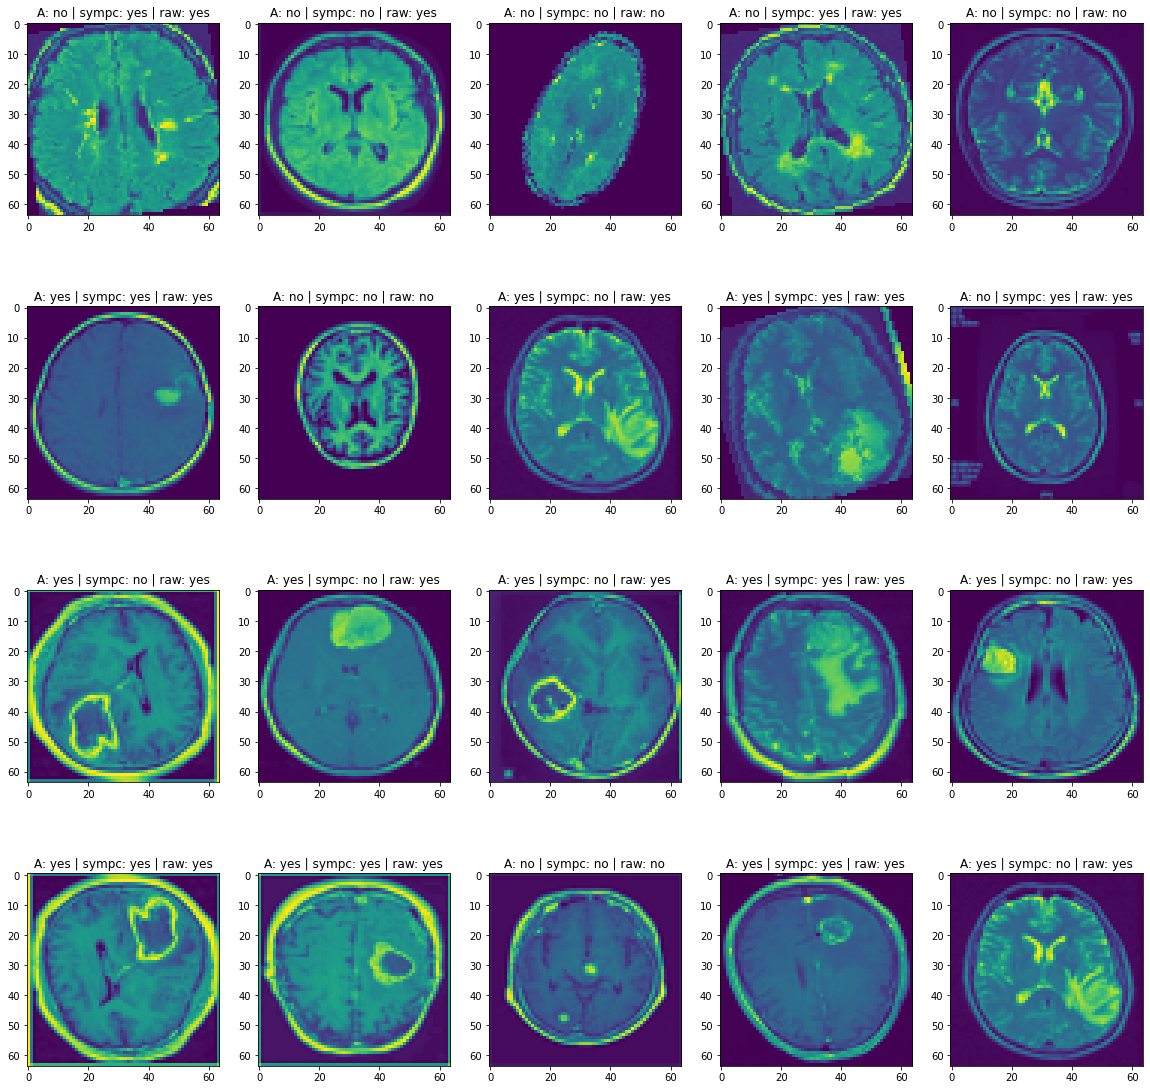

Time for inference: 2005.720060825348
Succes rate (sympc pred/actual labels):  0.58
Succes rate (sympc pred/raw pred):  0.68


In [24]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(20):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")

### advanced split data

In [26]:

imgs, lbls = next(iter(plot_loader))
data_to_split = []
for i, batch in enumerate(plot_loader):
    if i == 8: break
    img, lbl = batch
#     print(img)
    data_to_split.append(img)

print(len(data_to_split))


8


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


In [64]:
a_ptrs = []
a_labels = []
for i, (img, lbl) in enumerate(plot_loader):
    img_f = img.type(torch.float32)
    a_ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(a_ptrs)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


76

In [ ]:
import time
start_time = time.time()

a_results = []
a_encrypted_results =[]
i = 0
for ptr in a_ptrs:
    a_encrypted_result = mpc_model(ptr)
    print(f"encrypted results: {a_encrypted_results}")
#     a_plaintext_results = a_encrypted_results.reconstruct()
#     print(f"plain text results: {a_plaintext_results}")
#     a_results.append(a_plaintext_results)
    a_encrypted_results.append(a_encrypted_result)
    i+=1
    print(i)

end_time = time.time()
a_results

[2021-12-07T20:28:51.153785+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 480cee5808de410fa1939c93a3dc898c>.
[2021-12-07T20:28:51.161189+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0750da1e057419baa90c31ebf618762>.
[2021-12-07T20:29:57.973091+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57050a2850fc496f80e8f083fbbcb0d3>.
[2021-12-07T20:29:57.980058+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f69e2a80bac246d1bf82243f46531f8f>.
[2021-12-07T20:30:32.226423+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58b180b63de74e7fb4648401addd388e>.
[2021-12-07T20:30:32.229663+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79eb62aa4e0c44408bb66

encrypted results: []
1


[2021-12-07T20:30:41.921227+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88809a2a257c49ab80b2ead32367fd92>.
[2021-12-07T20:30:41.927590+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65648504576241c18b8d9579917077cf>.
[2021-12-07T20:30:42.230055+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad52cdd9c4ce4fc090d6f664e8e241b8>.
[2021-12-07T20:30:42.236173+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c2ce263868049d7867d18bd634dc989>.
[2021-12-07T20:31:49.590592+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e33de6391d9e46788d6aee8bd211c839>.
[2021-12-07T20:31:49.597773+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e226e97d40e48bfb6668

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
2


[2021-12-07T20:32:32.493620+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc057422efd14651ae5988472e67f4e5>.
[2021-12-07T20:32:32.499738+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 43adcf3d6b114ee7963ae289a8e0dae8>.
[2021-12-07T20:32:32.508981+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d2fe9842d484b56ac6292502ec54d54>.
[2021-12-07T20:32:32.518213+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0013b7f9fe4d46fba953eeff9c0f945a>.
[2021-12-07T20:33:39.091193+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e41af08d22d43dab492130daff81fd6>.
[2021-12-07T20:33:39.098017+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42dc34a5ac0f44cdada2d

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
3


[2021-12-07T20:34:21.160353+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e23f6c10ae594259b03fd49283e9e127>.
[2021-12-07T20:34:21.169417+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 126843f2fc454e0dad5a29d4358e1630>.
[2021-12-07T20:34:21.182740+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94a3696712044e5d99fd0395ae333c39>.
[2021-12-07T20:34:21.185532+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8b23b6e3e10494b82fcd2a16c62f1b7>.
[2021-12-07T20:34:21.195273+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97bec388893a462b90b948dc5d64d7be>.
[2021-12-07T20:34:21.198154+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acd3f1a0d9084e70905e7

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
4


[2021-12-07T20:36:14.269272+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 825e1515fd9943189fc6789f50ae66c6>.
[2021-12-07T20:36:14.276136+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79a0d583d7d94aacbdc3062c365e3a27>.
[2021-12-07T20:36:14.293954+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 64e0339df7644dfc8de2a67f89817820>.
[2021-12-07T20:36:14.299416+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d327c61d47bc4a919709db24712882b0>.
[2021-12-07T20:36:14.308340+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6f48d5a7ee3491fbc2ae3f273941288>.
[2021-12-07T20:36:14.310852+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd0ee9b42ff54fc0bbf4e

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
5


[2021-12-07T20:38:05.014875+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8256981d20c432c82d53f4ac7e9cca4>.
[2021-12-07T20:38:05.022479+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0cd9c8c0c03e4844b430b1ba18137000>.
[2021-12-07T20:38:05.044226+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff9131d8b6d14411bb212b3a23267f1d>.
[2021-12-07T20:38:05.047194+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6088d96222e47ae892de87a31e0e618>.
[2021-12-07T20:38:05.056385+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb5c2464dfc444cf90d0c805810cf371>.
[2021-12-07T20:38:05.058899+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47494fc6e059475d9bf29

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer]
6


[2021-12-07T20:39:57.636349+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c97f0c56b5e94b7e81fb33e0c0421e1f>.
[2021-12-07T20:39:57.642248+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b9f2ef6915046e3b3a9a344132aaac3>.
[2021-12-07T20:39:57.664985+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6958ce369664721b7034a03d7e9e176>.
[2021-12-07T20:39:57.668232+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb43dcddf43f456d813f2b32b882fa2c>.
[2021-12-07T20:39:57.672834+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20d014eca0594bc6a55eb28a83f65938>.
[2021-12-07T20:39:57.675522+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f302a06f3ad942058ac92

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:41:48.469825+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efbb914005454253b48ae2517d9a50d5>.
[2021-12-07T20:41:48.481686+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 669cc42db9904ffca7ae70a6d6fead89>.
[2021-12-07T20:41:48.492030+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d8801ba3ab244908c1a73b415f855ad>.
[2021-12-07T20:41:48.494704+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21d901ae50c342cba74a3d3095317d54>.
[2021-12-07T20:41:48.767598+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e71e6f019ef417980aea63665975c5d>.
[2021-12-07T20:41:48.770372+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7df88391be12467581387

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:43:40.725512+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41c0c215ca2047ad9e1b6d31a19ac3c2>.
[2021-12-07T20:43:40.735695+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32ed18c49b8e42ec8fd8b1cb32276fc4>.
[2021-12-07T20:43:40.750867+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 376f79ca37954cf7bf114c14313f0c0e>.
[2021-12-07T20:43:40.753770+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c779c9f676e48558862804fda1066e6>.
[2021-12-07T20:44:47.858318+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a00e2cc468c349dab6434fd9ec2e042d>.
[2021-12-07T20:44:47.871270+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46860e81bec84118b08c6

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:45:32.234758+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 481e68aa119e4be9b838584db04a1b4b>.
[2021-12-07T20:45:32.245723+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0356828d7944f25b7493858019f50e6>.
[2021-12-07T20:45:32.600294+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ea829b6b54945fa8e2c27be39272baa>.
[2021-12-07T20:45:32.603406+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48bc627234f9484d974622d3c0ff46bf>.
[2021-12-07T20:46:38.486377+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57c391ba32584798a4d5be76597a6ef1>.
[2021-12-07T20:46:38.494442+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 649581db9d064ff0a9a99

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:47:22.447144+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8956da1c08e9480a83fe1e712a1e44b4>.
[2021-12-07T20:47:22.455776+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3168abcf587d44b0a69b065919b45bce>.
[2021-12-07T20:48:29.552258+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 844fe4bd23454acd9ef863a8ed86a7e3>.
[2021-12-07T20:48:29.562994+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4d4d3178aeb48eeb673cba6a21437a4>.
[2021-12-07T20:49:02.983252+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02008c14b57e480990b80be342a8777a>.
[2021-12-07T20:49:02.986454+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cb27f2e67a64bb383081

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:49:13.050071+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7941ea0c4bf049c4b6b30eacf7449e36>.
[2021-12-07T20:49:13.062480+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0f77c33df9e48faaa83a67b3f9a0f54>.
[2021-12-07T20:49:13.083031+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92cd5d491302446dad6dc1c53b0d7fce>.
[2021-12-07T20:49:13.086181+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b969ad233c764c54aa2aca028000d169>.
[2021-12-07T20:49:13.095578+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f39b6f88ca3042a5b73e89c202b2a2b1>.
[2021-12-07T20:49:13.098153+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17176697a26d45faa9266

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:51:03.899739+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edb8fa4e0fe04f25984e89ad618dc196>.
[2021-12-07T20:51:03.907115+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 040870423a3f4086a29cdcd8cb031f43>.
[2021-12-07T20:51:03.932071+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09089a25016d4572a9d6b63446c8cdfb>.
[2021-12-07T20:51:03.935108+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05f6ad6a58ae4821825e07266b13747c>.
[2021-12-07T20:51:03.944281+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e033e7d69bc450cb1d4e95d1e5a58bd>.
[2021-12-07T20:51:03.946886+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d653a1e89b84054b0239

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:52:57.314167+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b361c3393b343b8887ed87940da581e>.
[2021-12-07T20:52:57.322639+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c61d67cfcecb4eeca70812ca12a53408>.
[2021-12-07T20:52:57.344474+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49dbea691d3e46e7bd8169323ab349c0>.
[2021-12-07T20:52:57.347092+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f19a0fefc1a4ce2927b95af62ec082a>.
[2021-12-07T20:52:57.355862+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b53b9c36dfb409991fe2dc1237cf0b2>.
[2021-12-07T20:52:57.358397+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02d99856d2694fcba7766

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:54:49.064126+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77871adee3a141958514ce146adb274b>.
[2021-12-07T20:54:49.077647+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfd77d35e3784921a006101d2e01b5b5>.
[2021-12-07T20:54:49.086348+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d88b287a76046f98cded8535f28fbd0>.
[2021-12-07T20:54:49.089196+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20545add8de74d3586eaad6fd6b064ae>.
[2021-12-07T20:55:57.858406+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 548748438f8e42a2a1d83ecbfbc4ee1f>.
[2021-12-07T20:55:57.866615+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10527c64493d48dc98dae

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:56:42.348105+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eee18c571fcd4198aa3aaf8292c1c146>.
[2021-12-07T20:56:42.363103+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2eb26740f3bd43cebb338ee26af3cac7>.
[2021-12-07T20:56:42.374802+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c37f80e020554b039e100757b126fcef>.
[2021-12-07T20:56:42.378208+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec70e60b530f4e15a8dadb390212dfdc>.
[2021-12-07T20:57:51.447461+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75a07eb517a843108d6cf866b62b4bfc>.
[2021-12-07T20:57:51.458206+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d90bbf2413d041e78b8d1

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T20:58:36.958871+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 783f726f8b314e57b72b7d3a6a761a1e>.
[2021-12-07T20:58:36.966541+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24c8479cc2bc4630b15b67f6dcf25caa>.
[2021-12-07T20:58:37.297828+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14fbe082f1dc461eb339304aadbabc85>.
[2021-12-07T20:58:37.300909+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a04fe14af8bb4f4b98498a2b48b62a9a>.
[2021-12-07T20:59:45.228336+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e5a644a749e46268e4e1b19f410efd4>.
[2021-12-07T20:59:45.237961+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1038268b7b1f4ca68c2fe

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:00:29.451764+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25b7278fb5bd444bb9bd6bcb64b9429a>.
[2021-12-07T21:00:29.459717+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17ae65a449e048c3bb28e5157d434c3e>.
[2021-12-07T21:00:29.719024+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 717a6c76438e42e7b0521ace3804d1ba>.
[2021-12-07T21:00:29.721860+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 387c3046a193496e9ee6d330521539e8>.
[2021-12-07T21:01:36.879034+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4e520fa275647c090a30b9120a78206>.
[2021-12-07T21:01:36.887530+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b1dedafb20d462fa2138

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:02:19.670799+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f2b77be64b145b98510e1942ecc58cf>.
[2021-12-07T21:02:19.682231+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7bc68028044a4040932b2e519ce8bca1>.
[2021-12-07T21:03:27.385269+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd07e564d25e4206a14eb1a2a808f782>.
[2021-12-07T21:03:27.393212+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23438f83145b4f708cc6c00f98adc2d3>.
[2021-12-07T21:04:02.033665+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d177e4399ef74b1f98cbfb2e9d4b974d>.
[2021-12-07T21:04:02.036919+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cacea9e4e5e4d4d800f3

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:04:12.206581+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 777975556ab24bd394a51ec265d44739>.
[2021-12-07T21:04:12.217867+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fca975e7fb4a40fab546905f1f12f7f7>.
[2021-12-07T21:05:19.602902+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74b4315830274d738426bfb92ec149ac>.
[2021-12-07T21:05:19.612712+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bf0bdd08cc74a63814444183228e55e>.
[2021-12-07T21:05:53.738399+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69d528c740b04787907fb330b33c0d7e>.
[2021-12-07T21:05:53.741797+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97c60d59c4034e5083702

encrypted results: [[MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer, [MPCTensor]
Shape: torch.Size([1, 2])
Re

[2021-12-07T21:06:03.814345+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81e32cd58608418ab44527de5239c787>.
[2021-12-07T21:06:03.822083+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1460f17f7f7443e7a733ef292794e063>.
[2021-12-07T21:07:11.774261+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e46ad7ae3b347888d902115eab58392>.
[2021-12-07T21:07:11.783012+0000][CRITICAL][logger]][7696] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c085efe183ec4eb6a6933ad37e0e5d58>.


In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")



lxd tutorial 